Data loaded: 1337 rows, 7 columns


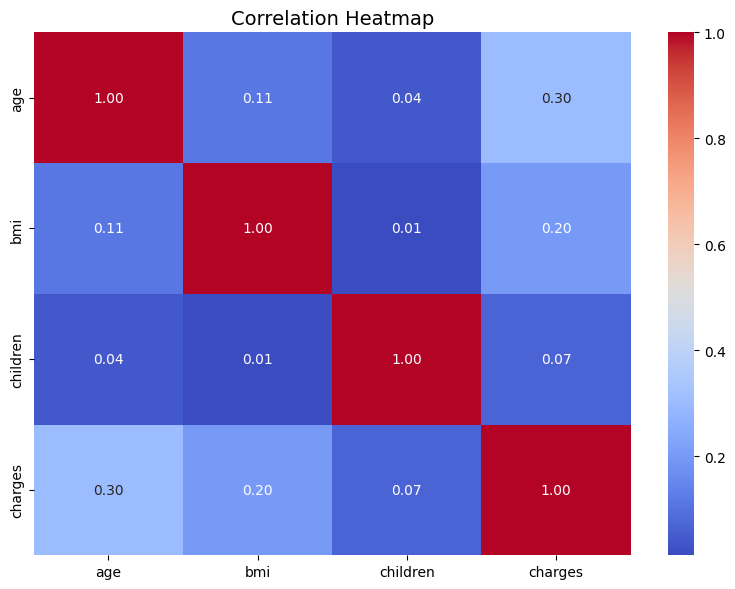

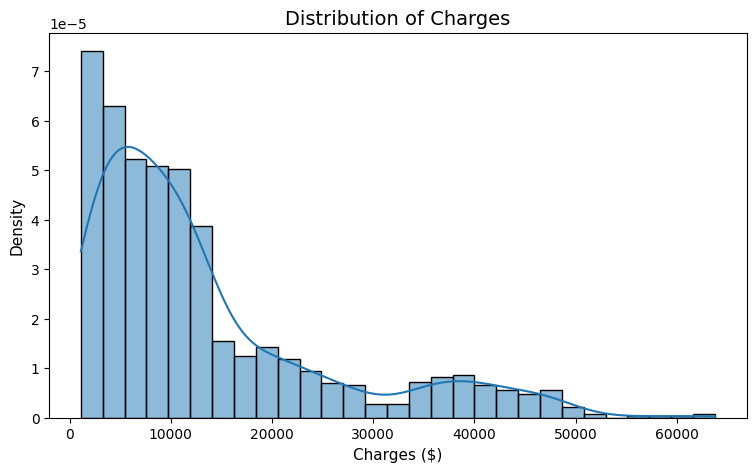

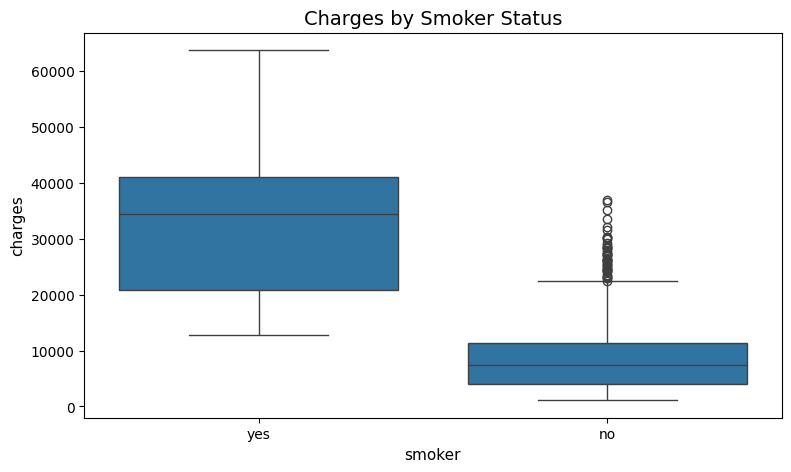

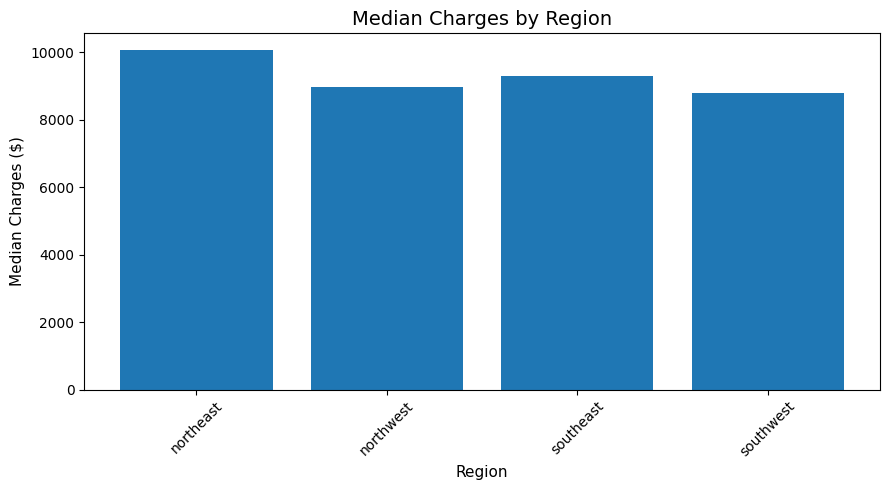

Training Random Forest model...
Random Forest Performance:
RMSE: 4729.97
R²: 0.878


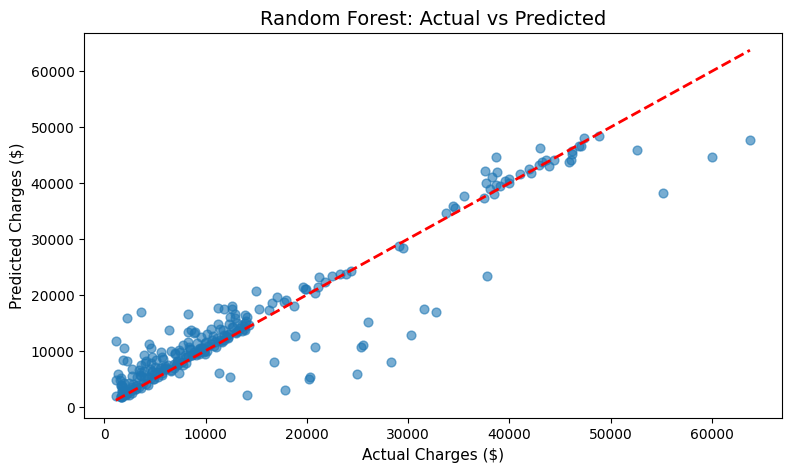

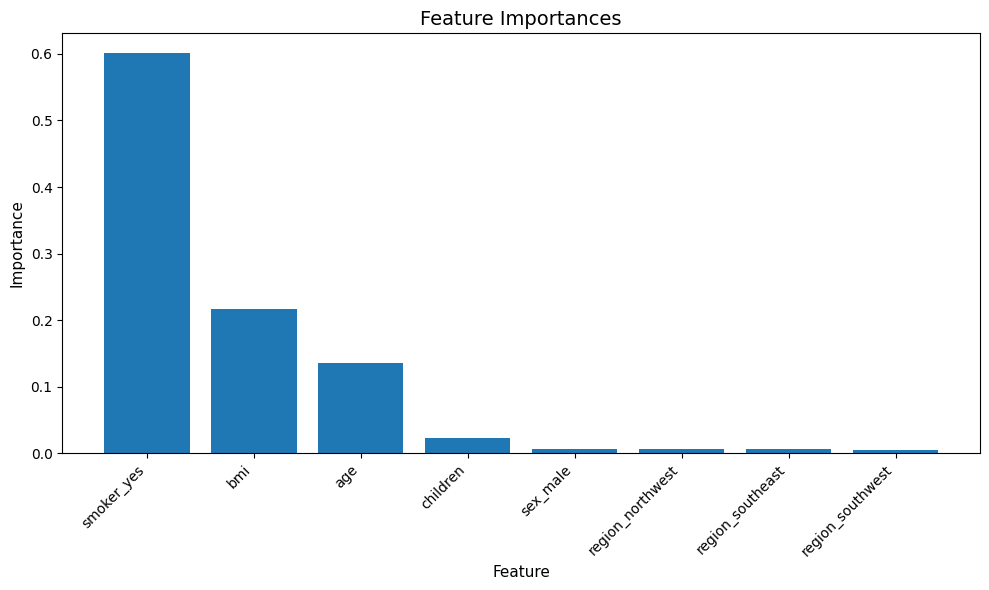

To start the interactive premium estimator, run: interactive_premium_estimator()
For direct estimation, use: estimate_premium(age, sex, bmi, children, smoker, region)

Example prediction: $23,490.94

Notebook complete!
Hi! I am an Insurance Premium Estimator designed by Younus.
I am going to ask a few questions which will allow me to generate a premium.

Please enter an age between 18 and 100.
Question 6 of 6: What region are you in?
Write 1 for northeast, 2 for northwest, 3 for southeast, 4 for southwest

PREMIUM CALCULATION COMPLETE
Your estimated insurance premium is: $46,651.76

Summary of your profile:
• Age: 99 years
• Gender: Female
• BMI: 33.0
• Children: 0
• Smoker: Yes
• Region: Northwest


46651.7627235

In [ ]:
# =============================
# Insurance Premium Prediction Notebook
# Simplified version with Random Forest only
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set plotting style
plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 11
})

# -----------------------------
# Load and clean data
# -----------------------------
df = pd.read_csv("insurance.csv")

# Data cleaning
df_clean = df.copy()
df_clean = df_clean.drop_duplicates().reset_index(drop=True)

# Standardize categorical columns
for col in ["sex", "smoker", "region"]:
    df_clean[col] = df_clean[col].astype(str).str.strip().str.lower()

# Ensure numeric types
df_clean["age"] = pd.to_numeric(df_clean["age"], errors="coerce").astype(int)
df_clean["bmi"] = pd.to_numeric(df_clean["bmi"], errors="coerce")
df_clean["children"] = pd.to_numeric(df_clean["children"], errors="coerce").astype(int)
df_clean["charges"] = pd.to_numeric(df_clean["charges"], errors="coerce")

print(f"Data loaded: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")

# -----------------------------
# EDA Charts
# -----------------------------

# Correlation heatmap
plt.figure(figsize=(8,6))
corr = df_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Charges distribution
plt.figure(figsize=(9,5))
sns.histplot(df_clean["charges"], kde=True, stat="density")
plt.title("Distribution of Charges")
plt.xlabel("Charges ($)")
plt.show()

# Charges by smoker
plt.figure(figsize=(9,5))
sns.boxplot(data=df_clean, x="smoker", y="charges")
plt.title("Charges by Smoker Status")
plt.show()

# BMI vs Charges (interactive)
fig = px.scatter(df_clean, x="bmi", y="charges", color="smoker",
                 title="BMI vs Charges by Smoker")
fig.show()

# Charges by region
region_med = df_clean.groupby("region")["charges"].median()
plt.figure(figsize=(9,5))
plt.bar(region_med.index, region_med.values)
plt.title("Median Charges by Region")
plt.xlabel("Region")
plt.ylabel("Median Charges ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Model Training
# -----------------------------

# Prepare features
X = df_clean.drop(columns=["charges"])
y = df_clean["charges"]

numeric_features = ["age", "bmi", "children"]
categorical_features = ["sex", "smoker", "region"]

# Create preprocessor
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train Random Forest model
rf_pipeline = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

print("Training Random Forest model...")
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = rf_pipeline.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# -----------------------------
# Model Diagnostics
# -----------------------------

# Actual vs Predicted
plt.figure(figsize=(9,5))
plt.scatter(y_test, y_pred, alpha=0.6, s=40)
minv = min(y_test.min(), y_pred.min())
maxv = max(y_test.max(), y_pred.max())
plt.plot([minv, maxv], [minv, maxv], linestyle="--", color="red", linewidth=2)
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Charges ($)")
plt.ylabel("Predicted Charges ($)")
plt.show()

# Feature importances
rf = rf_pipeline.named_steps["model"]
num_names = numeric_features
cat_transformer = rf_pipeline.named_steps["pre"].named_transformers_["cat"]
cat_names = list(cat_transformer.get_feature_names_out(categorical_features))
feat_names = num_names + cat_names

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), [feat_names[i] for i in sorted_idx], rotation=45, ha="right")
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# -----------------------------
# Interactive Premium Estimation Function
# -----------------------------
def interactive_premium_estimator():
    """
    Interactive insurance premium estimator with guided questions.
    """
    print("=" * 60)
    print("Hi! I am an Insurance Premium Estimator designed by Younus.")
    print("I am going to ask a few questions which will allow me to generate a premium.")
    print("=" * 60)
    print()
    
    # Question 1 - Age
    while True:
        try:
            age = int(input("Question 1 of 6: What is your age? "))
            if 18 <= age <= 100:
                break
            else:
                print("Please enter an age between 18 and 100.")
        except ValueError:
            print("Please enter a valid number for age.")
    
    # Question 2 - Sex
    while True:
        sex_input = input("Question 2 of 6: Please tell me if you are Male or Female. Write M for Male and F for Female: ").strip().upper()
        if sex_input in ['M', 'F']:
            sex = 'male' if sex_input == 'M' else 'female'
            break
        else:
            print("Please enter M for Male or F for Female.")
    
    # Question 3 - BMI
    while True:
        try:
            bmi = float(input("Question 3 of 6: What is your BMI in numbers? "))
            if 15 <= bmi <= 50:
                break
            else:
                print("Please enter a BMI between 15 and 50.")
        except ValueError:
            print("Please enter a valid number for BMI.")
    
    # Question 4 - Children

    while True:

        try:

            children = int(input("Question 4 of 6: How many children do you have in number format? "))

            if children >= 0:

                break

            else:

                print("Please enter 0 or a positive number.")

        except ValueError:

            print("Please enter a valid number for children.")

   

    # Question 5 - Smoker

    while True:

        smoker_input = input("Question 5 of 6: Are you a smoker? Type 'yes'  or 'no'").strip().lower()

        if smoker_input in ['yes', 'no']:

            smoker = smoker_input

            break

        else:

            print("Please enter yes or no.")

   

    # Question 6 - Region

    print("Question 6 of 6: What region are you in?")

    print("Write 1 for northeast, 2 for northwest, 3 for southeast, 4 for southwest")

    while True:

        try:

            region_input = int(input("Enter your choice (1-4): "))

            if region_input == 1:

                region = 'northeast'

                break

            elif region_input == 2:

                region = 'northwest'

                break

            elif region_input == 3:

                region = 'southeast'

                break

            elif region_input == 4:

                region = 'southwest'

                break

            else:

                print("Please enter 1, 2, 3, or 4.")

        except ValueError:

            print("Please enter a valid number (1-4).")
    
    # Generate prediction
    input_df = pd.DataFrame([{
        "age": age,
        "sex": sex,
        "bmi": bmi,
        "children": children,
        "smoker": smoker,
        "region": region
    }])
    
    prediction = rf_pipeline.predict(input_df)[0]
    
    print("\n" + "=" * 60)
    print("PREMIUM CALCULATION COMPLETE")
    print("=" * 60)
    print(f"Your estimated insurance premium is: ${prediction:,.2f}")
    print()
    print("Summary of your profile:")
    print(f"• Age: {age} years")
    print(f"• Gender: {sex.title()}")
    print(f"• BMI: {bmi}")
    print(f"• Children: {children}")
    print(f"• Smoker: {smoker.title()}")
    print(f"• Region: {region.title()}")
    print("=" * 60)
    
    return prediction

def estimate_premium(age, sex, bmi, children, smoker, region):
    """
    Direct premium estimation function (for programmatic use).
    """
    # Normalize inputs
    sex = str(sex).strip().lower()
    smoker = str(smoker).strip().lower()
    region = str(region).strip().lower()
    
    input_df = pd.DataFrame([{
        "age": int(age),
        "sex": sex,
        "bmi": float(bmi),
        "children": int(children),
        "smoker": smoker,
        "region": region
    }])
    
    prediction = rf_pipeline.predict(input_df)[0]
    return prediction

# Run the interactive estimator
print("To start the interactive premium estimator, run: interactive_premium_estimator()")
print("For direct estimation, use: estimate_premium(age, sex, bmi, children, smoker, region)")

# Example of direct usage
sample_prediction = estimate_premium(40, "male", 28.5, 2, "yes", "southeast")
print(f"\nExample prediction: ${sample_prediction:,.2f}")

print("\nNotebook complete!")

# Automatically start the interactive estimator
interactive_premium_estimator()